In [1]:
# Author: Chase J. Shyu
# Email: iamhemry@gmail.com
# Created date: June 3rd, 2021
# Updated date: July 2rd, 2021
import datetime, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import warnings
warnings.filterwarnings("ignore")
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib?lq=1
def gradient_fill(x, y, fill_color=None, palpha=1, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y,color=fill_color, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, palpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = mpatches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    patche = mpatches.Patch(color=fill_color,alpha=palpha)

    ax.autoscale(True)
    return line, patche

In [2]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def verticalizeText(text):
    text = text.strip()
    text_v = ''        
    isE = [isEnglish(t) for t in text]
    for j in range(len(text)):
        if text[j] == ' ':
            continue
        if j < len(text)-1:
            if text[j] == '/':
                enter = True
            elif j < len(text)-2:
                if text[j+1] == '/':
                    enter = True
                elif text[j+1] == '#':
                    enter = True
                elif isE[j] and isE[j+1]:
                    enter = False
                elif isE[j] and not isE[j+1]:
                    enter = True
                elif not isE[j] and isE[j+1]:
                    enter = True
                elif not isE[j] and not isE[j+1]:
                    enter = True
            elif isE[j] and isE[j+1]:
                enter = False
            elif isE[j] and not isE[j+1]:
                enter = True
            elif not isE[j] and isE[j+1]:
                enter = True
            elif not isE[j] and not isE[j+1]:
                enter = True
        else:
            enter = False

        if enter:
            text_v += text[j] + '\n'
        else: 
            text_v += text[j]
    
    return text_v

In [ ]:
#!python3 data_processing.py

In [4]:
# 2021/04台灣人口 23,514,196
# Wikipedia: https://zh.wikipedia.org/zh-tw/臺灣人口
population_202104 = 23514196
pop_cities = pd.read_csv('populations.csv')
pop202104_cities = dict(zip(pop_cities.iloc[:,0].tolist(),pop_cities.iloc[:,1].tolist()))
vaccine_prec = 0.65
vacNumber = round(population_202104*vaccine_prec*2)
first_date = datetime.datetime.fromisoformat('2021-03-01')
last_date = datetime.datetime.today() + datetime.timedelta(days=0)
dpi = 150

# for read data
# data all from CDC
csv_filename = 'VaccineCOVID19Taiwan - public.csv'
Date = '日期'
Event = '事件'
ReleasedVaccine = '累計疫苗釋出'
VaccineCheck = '疫苗檢查'
InjectedAmount = '累計施打'
InjectedAmountCorrect = '校正累計施打'
ConfirmedLocalAmount = '累計本土確診'
ConfirmedLocalDaily = '單日本土確診'
ConfirmedLocalCorrectDaily = '單日本土增補'
DeathAmount = '累計死亡'
DeathDaily = '單日死亡'
ArrivedAmount = '累計疫苗抵臺'
FinalCorrectAmount = '完成本土增補'

# read data
df = pd.read_csv(csv_filename)
df = df[~df[Date].isnull()]
df.loc[:,Date] = df[Date].astype('datetime64[ns]')
df.set_index(Date,inplace=True)
ind = (df.index >= first_date + datetime.timedelta(days=-1)) * (df.index <= last_date.strftime('%Y-%m-%d'))
df = df[ind]
df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmountCorrect] = \
    df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmount]

ind = df[InjectedAmountCorrect].isnull()
df[InjectedAmountCorrect][ind] = df[InjectedAmount][ind]
df['mavg'] = df[InjectedAmountCorrect].interpolate()

#
covid_ylim_max = 800
covid_y_interval = 200
covid_y_interval_minor = 100
vac_ylim_times = 1
vacc_ylim_max = 1450
prog_ylim_ratio = 1.5
prog_y_interval = 5
vacc_y_interval = 1
vacc_y_interval_minor = 0.5
figsize = (24, 12)

# for plot
title = '臺灣COVID-19疫苗接種統計報表'
title_prog = '臺灣COVID-19疫苗取得/使用進度'
title_inter = '第類疫苗接種進度(第1劑)'
label_right = '新增本土確診/死亡︵人︶'
label_left = '疫苗接種(%)'
label_bottom = '事件/統計日期(西元)'
label_taiwan_vac = '疫苗接種(劑/人口)'
label_confirmed = '新增本土確診(人)'
label_correction = '累計校正回歸(人)'
label_death = '新增死亡(人)'
text_population = '臺灣人口基數(2021-04)：'+ f'{population_202104:,}' +'人'
text_last_updated = '最後更新日期：%s'%(df.index[-1] + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')
confirmedAmount = int(df[ConfirmedLocalAmount].max())
deathDeath = int(df[DeathAmount].max())
text_confirmed_amount = '累計本土確診/死亡：' + f'{confirmedAmount:,}/' + f'{deathDeath:,}' +'人'
text_vaccine_estimation = '假設總人口x2x%d'%(vaccine_prec*100) + '%：' + f'{vacNumber:,}' + '劑'
text_sign = ': VaccineCOVID19Taiwan'

label_sub_bottom = '事件日期(西元)'
label_dose_number = '數量︵百萬劑︶'
label_progress = '疫苗取得(%)'
label_await = '待檢驗(百萬劑)'
label_available = '可施打(百萬劑)'

label_legend_background = ['第一級','第二級','第三級','感染','疫苗']
title_legend_background ='全國疫情警戒                事件'

vaccine_color = '#6F00D2'
color_city_vaccine = '#CA8EFF'
color_city_marker = '#8080C0'
alpha_city_vaccine = 1
death_color = 'red'
confirmd_color = '#FFAD86'
correction_color = 'gold'
#progress_axis_color = 'black'
#progress_color
progress_text_color = 'black'
number_color = '#5B00AE'
availble_color = 'blue'
await_color = 'red'
title_size = 36
label_size = 20
tick_size = 16
legend_title_size = 12
subplot_label_size = 12
event_size = 10
main_alpha = 1
vaccine_lw = 2
sub_lw = 1.5

# infected dates
dates_infected = ['2021-04-22','2021-04-29','2021-05-11','2021-05-12','2021-05-23',
                  '2021-06-01','2021-06-23','2021-07-02']

# background zones
alpha_level1 = 0.2
color_level1 = 'lightgreen'
alpha_level2 = 0.2
color_level2 = 'gold'
alpha_level3 = 0.2
color_level3 = 'orange'
alpha_alert = 1
color_alert = '#FFD2D2'
alpha_vaccine = 1
color_vaccine = '#D2E9FF'

xmax = df.index[-1]



# plot
# https://medium.com/@jackielo_69076/mac-matplotlib-顯示中文-e10c8394300c
from matplotlib.font_manager import _rebuild
_rebuild()
font = ['SimHei','jf-jinxuan-fresh2.2']
mpl.rcParams['font.sans-serif']=[font[0]]
mpl.rcParams['axes.unicode_minus']=False

mpl.rcParams['xtick.labelsize'] = tick_size
mpl.rcParams['ytick.labelsize'] = tick_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size

#from matplotlib import rc
## for CorelDraw
#rc("pdf", fonttype=42)

In [5]:
def plot_sub(ax_vac_num,combo=0):
    ax_progress = ax_vac_num.twinx()
    #await vaccion
    ax_vac_num.set_zorder(6)
    ax_progress.set_zorder(7)
    df2 = df[df.index < last_date + datetime.timedelta(days=-1)]
    dd = np.vstack((df2.index[:-1],df2.index[1:])).T.reshape((1,-1),)[0]
    yvalue = (df2[ArrivedAmount]-df2[VaccineCheck].fillna(0).cumsum()-df2[ReleasedVaccine])*1e-6
    aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
#    ax_vac_num.plot(dd,aa,'-',color=await_color,label=label_await,lw=1,zorder=5)
    lim_y_max = ax_vac_num.get_ylim()[1]
    _, im_await = gradient_fill(mdates.date2num(dd),aa,await_color,ax=ax_vac_num,palpha=0.75,lw=1)

    # available vaccine
    df2 = df[df.index < last_date + datetime.timedelta(days=-1)]
    dd = np.vstack((df2.index[:-1],df2.index[1:])).T.reshape((1,-1),)[0]

    delta_vaccine = (df2[ReleasedVaccine]-df2['mavg'].fillna(0)) *1e-6
    delta_vaccine[delta_vaccine >= 0] = pd.np.nan
    ind0 = delta_vaccine.index[~delta_vaccine.isnull()][0]
    delta = delta_vaccine[ind0:].interpolate()
    yvalue = (df2[ReleasedVaccine]-df2['mavg'].fillna(0))*1e-6
    yvalue[delta.index] = yvalue[delta.index] - delta
    aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
    #ax_vac_num.plot(dd,aa,'-',color=availble_color,label=label_available,lw=1,zorder=5)
    _, im_available = gradient_fill(mdates.date2num(dd),aa,availble_color,ax=ax_vac_num,palpha=0.75,lw=1)

    ax_vac_num.set_ylabel(verticalizeText(label_dose_number),fontsize=label_size,rotation=0,va='center')
    ax_vac_num.yaxis.set_label_coords(1.09,0.65)
    ax_vac_num.set_ylim(0,ax_vac_num.get_ylim()[1]*1.1)
#    ax_vac_num.set_xlim(,last_date.strftime('%Y-%m-%d'))
    ax_vac_num.tick_params(which='major', length=7.5, width=1.5)

    for axis in ['top','bottom','right']:
        ax_vac_num.spines[axis].set_linewidth(1.5)
    ax_vac_num.spines['right'].set_color(number_color)
    ax_vac_num.yaxis.label.set_color(number_color)
    ax_vac_num.tick_params(axis='y',colors=number_color)
    ax_vac_num.spines['left'].set_visible(False)
    ax_vac_num.yaxis.tick_right()
    ax_vac_num.yaxis.set_label_position("right")


    # obtainment
    dd = np.vstack((df.index[:-1],df.index[1:])).T.reshape((1,-1),)[0]
    aa = np.vstack((df[ArrivedAmount][:-1],df[ArrivedAmount][:-1])).T.reshape((1,-1),)[0]
    ax_progress.plot(dd,aa / (population_202104*vaccine_prec*2) * 100,'--',
                     color=progress_text_color,label=label_progress,lw=2,zorder=5)

    y_shift = ax_progress.get_ylim()[1]*0.02
    ind = ~df[Event].isnull() & (df.index < (last_date + datetime.timedelta(days=-1)))
    for i in df[ind].index:
        if '抵臺' in df.loc[i,Event]:
            ycoord = df.loc[i,ArrivedAmount] / (population_202104*vaccine_prec*2) * 100 + y_shift
            text = verticalizeText(df.loc[i,Event].split('/')[0])
            ax_progress.text(i,ycoord, text + '\n$\downarrow$ ',
                             zorder=6,rotation=0,fontsize=event_size,
                             horizontalalignment='center',color=progress_text_color,
                             bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1,'alpha':0.6})

    ax_progress.set_xlim(first_date,df.index[-1])
    ax_progress.set_ylim(0,ax_progress.get_ylim()[1]*prog_ylim_ratio)#prog_ylim_ratio)


            
    ax_progress.set_title(title_prog,fontsize=label_size,y=1.005)
    ax_progress.yaxis.tick_left()
    ax_progress.yaxis.set_label_position("left")
    ax_progress.yaxis.set_label_coords(-0.07,0.5)
    ax_progress.set_xlabel(label_sub_bottom,fontsize=label_size)
    ax_progress.set_ylabel(verticalizeText(label_progress),fontsize=label_size,rotation=0,va='center')
    ax_progress.set_yticks(np.arange(0, ax_progress.get_ylim()[1]*prog_ylim_ratio, prog_y_interval)[:-1])
    ax_progress.tick_params(axis='y',labelsize=tick_size)
    ax_progress.spines['right'].set_visible(False)
    for axis in ['top','bottom','left']:
        ax_progress.spines[axis].set_linewidth(1.5)
    ax_progress.spines['left'].set_color(progress_text_color)
    ax_progress.tick_params(which='major', length=7.5, width=1.5)
    ax_progress.xaxis.set_major_locator(mdates.MonthLocator())
    ax_progress.yaxis.label.set_color(progress_text_color)
    ax_progress.tick_params(axis='y',colors=progress_text_color)
    ax_progress.grid(axis='y',linestyle = '--', linewidth = 1,color='darkgray')

    if combo == 0:
        ax_vac_num.set_xlabel(label_sub_bottom,fontsize=label_size)


    
    hs0, ls0 = ax_progress.get_legend_handles_labels()
    hs1, ls1 = ax_vac_num.get_legend_handles_labels()
    legend1 = ax_progress.legend(hs0+[im_await,im_available],ls0+[label_await,label_available],
                                 loc=2,bbox_to_anchor=(0, 1),title=text_vaccine_estimation,fontsize=label_size)
    ax_progress.add_artist(legend1)
    #ax_progress.legend(loc=2,bbox_to_anchor=(0.345, 1),fontsize=label_size,title=text_vaccine_estimation)
    #ax_vac_num.legend(loc=2,bbox_to_anchor=(0, 1),fontsize=label_size)

    if combo == 0:
        ax_progress.text(xmax,ax_progress.get_ylim()[1]*1.023,
                    text_last_updated,
                   fontsize=tick_size-5,ha='right',va='bottom')
        ab = AnnotationBbox(OffsetImage(plt.imread("github.png"), zoom=.055),
                            (0.83, -.1255), xycoords='axes fraction',box_alignment=(1,0),
                            pad=-3,bboxprops={'edgecolor':'none'})
        ax_progress.add_artist(ab)
        ax_progress.text(xmax,-ax_progress.get_ylim()[1]*0.11,text_sign,fontsize=tick_size-5,ha='right',va='bottom')

    
def plot_class(ax_class,combo=0):
    ax_class.set_zorder(9)
    df_class = pd.read_csv('injection_class.csv')

    ind = ['累計第' in c for c in df.columns]
    cols = df.columns[ind][10:60:6]
    orders = [0,1,2,3,4,5,6,7,8]
#    orders = [0,1,2,7,3,6,5]
    cols = cols[orders]
    col_label = ['#%d'%(i+1)+c[5:-3] for i, c in enumerate(cols)]
    col_label[5] = col_label[5]+'\n&'+col_label[6][2:]
    col_label[6] = '#7'+ col_label[7][2:]+'&'+col_label[8][2:]
    col_label = np.array(col_label)
    class_selected = [0,1,4,5,6]
    isNotNull = ~ df[cols[0]].isnull()
    ind_last = df[isNotNull].index[-1]
    #df[cols] = df[cols].interpolate()
    class_acc = df.loc[ind_last,cols].to_numpy()
    class_acc[5] += class_acc[6]
    class_acc[6] = class_acc[7] + class_acc[8]
    class_acc = class_acc[:-2]
    class_pop = np.array(df_class['人數_0621'])[:7]
    class_name = np.array(df_class['類別'])[:7]
    class_ratio = class_acc/class_pop
    class_remnant = class_pop - class_acc
    class_remnant[class_remnant < 0] = 0
    class_acc[class_acc>class_pop] = class_pop[class_acc>class_pop]
    
    data = np.concatenate((class_acc,class_remnant)).reshape(2,-1).T
    vals = data[class_selected]
    class_name = class_name[class_selected]
    class_ratio = class_ratio[class_selected]
    col_label = col_label[class_selected]
    class_pop = class_pop[class_selected]
    #fig, ax_class = plt.subplots(1,1,figsize=figsize,dpi=300,subplot_kw=dict(polar=True))
    
    size = 0.3
    # data sets
    nsets = len(class_selected)
    #normalize vals to 2 pi
    valsnorm = vals/np.sum(vals)*2*np.pi
    #obtain the ordinates of the bar edges
    valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(nsets)*4)
    inner_colors = cmap(np.arange(nsets*2)*2+1)


    
    ax_class.bar(x=valsleft[:, 0],
           width=valsnorm.sum(axis=1), bottom=1-2*size, height=size,
           color=outer_colors, edgecolor='w', linewidth=1, align="edge")

        
    dx = [0,-np.pi/90,+np.pi/90,+np.pi/45,0]
    yy = np.array([2.,1.9,2.29,2.3,2.])*size
    c = ['w','w','k','k','w']
    for i, x in enumerate(valsleft[:, 0]+ valsnorm.sum(axis=1)/2):
        xx = x + dx[i]
        msg = col_label[i] + '\n%.1f萬人'%(class_pop[i]*1e-4)
#        color = outer_colors[i][:]
#        color[:3] = 1-outer_colors[i][:3]
        ax_class.text(xx,yy[i],msg,ha='center',va='center',color=c[i],fontsize=8)

    ax_class.bar(x=valsleft.flatten(),
           width=valsnorm.flatten(), bottom=1-size, height=size,
           color=inner_colors, edgecolor='w', linewidth=1, align="edge")

    # outside
    for i, x in enumerate((valsleft.flatten()+ valsnorm.flatten()/2)[::2]):
#        if i == 3:
#            xx, yy = x*1.05, size*3.8
#        elif i == 1:
#            xx, yy = x*0.95, size*3.8
#        else:
        xx, yy = x, size*4
        ax_class.text(xx,yy,'%.2f'%(class_ratio[i]*100) + '%',ha='center',va='center',fontsize=10,
                     color=outer_colors[i])

    msg = '%d'%(class_selected[0]+1)
    for s in class_selected[1:]:
        msg += ',%d'%(s+1)
    
    ax_class.set_title(title_inter[0] + msg + title_inter[1:],y=0.5,va='top',fontsize=10,
                       bbox={'facecolor':'white', 'edgecolor':'none','alpha':0.6})
    ax_class.set_axis_off()
    ax_class.text(-np.pi/2,0.2,ind_last.strftime('(%Y-%m-%d)'),ha='center',fontsize=10)
    

    if combo == 0:
        ab = AnnotationBbox(OffsetImage(plt.imread("github.png"), zoom=.035),
                            (0.39, -.072), xycoords='axes fraction',box_alignment=(1,0),
                            pad=-1,bboxprops={'edgecolor':'none'})
        ax_class.add_artist(ab)


        ax_class.text(-np.pi/2,ax_class.get_ylim()[1]*1.1,'        '+text_sign,fontsize=tick_size-9,ha='center',va='bottom')



In [6]:
def plot_background_color(ax):
    # infected events
    for d in dates_infected:
        date0 = mdates.date2num(datetime.datetime.fromisoformat(d) - datetime.timedelta(hours=12))
        date1 = mdates.date2num(datetime.datetime.fromisoformat(d) + datetime.timedelta(hours=12))
        zone_alert = ax.axvspan(date0, date1 , facecolor=color_alert, alpha=alpha_alert,zorder=1)

    # level zones
    date0 = ax.get_xlim()[0]
    date1 = mdates.date2num(datetime.datetime.fromisoformat('2021-05-11'))
    zone_level1 = ax.axvspan(date0, date1 , facecolor=color_level1, alpha=alpha_level1,zorder=0)
    date2 = mdates.date2num(datetime.datetime.fromisoformat('2021-05-19'))
    zone_level2 = ax.axvspan(date1, date2 , facecolor=color_level2, alpha=alpha_level2,zorder=0)
    date3 = ax.get_xlim()[1]
    zone_level3 = ax.axvspan(date2, date3 , facecolor=color_level3, alpha=alpha_level3,zorder=0)

    # vaccine events
    ind = ~df[Event].isnull() & (df.index < (last_date + datetime.timedelta(days=-1)))
    #date = df.loc[ind,Date]
    for i in df[ind].index:
        if '抵臺' in df.loc[i,Event]:
            date0 = mdates.date2num(i - datetime.timedelta(hours=12))
            date1 = mdates.date2num(i + datetime.timedelta(hours=12))
            zone_vaccine = ax.axvspan(date0, date1 , facecolor=color_vaccine, alpha=alpha_vaccine,zorder=1)
    date0 = mdates.date2num(datetime.datetime.fromisoformat('2021-06-10') - datetime.timedelta(hours=12))
    date1 = mdates.date2num(datetime.datetime.fromisoformat('2021-06-10') + datetime.timedelta(hours=12))
    zone_vaccine = ax.axvspan(date0, date1 , facecolor=color_vaccine, alpha=alpha_vaccine,zorder=1)

    return zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine


In [7]:
def plot_event(ax_event, combo=0):

    event_ylim_ratio = 1.8
    # plot vaccine injected amount
    plot_vaccine_first(ax_event)

    plot_vaccine_second(ax_event)

    plot_event_text(ax_event)

    zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine = plot_background_color(ax_event)

    ax_event.set_ylim(0,ax_event.get_ylim()[1]*event_ylim_ratio)#prog_ylim_ratio)
    ax_event.set_xlim(first_date,df.index[-1])

    ax_event.set_yticks([])
#    ax_event.set_yticks(np.arange(0, ax_event.get_ylim()[1]+.1, vacc_y_interval_minor), minor=True)
    #ax_progress.set_zorder(0)
#    ax_event.set_ylim(0,)#math.ceil(ax_vaccine.get_ylim()[1] * vac_ylim_times))
#    ax_event.set_xlim(first_date,xmax)
    ax_event.set_ylabel(verticalizeText('事件'), fontsize=label_size,va='center',rotation=0)
    ax_event.yaxis.set_label_coords(-0.01,0.5)
    ax_event.set_title('臺灣COVID-19相關事件',fontsize=title_size,y=1.02)
    ax_event.text(xmax,ax_event.get_ylim()[1]*1.035,
                    text_last_updated,
                   fontsize=tick_size,ha='right',va='bottom')
    
    ab = AnnotationBbox(OffsetImage(plt.imread("github.png"), zoom=.08),
                    (0.895, -.077), xycoords='axes fraction',box_alignment=(1,0),
                    pad=-3,bboxprops={'edgecolor':'none'})
    ax_event.add_artist(ab)
    ax_event.text(xmax,-ax_event.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')

    #ax_vaccine.spines['top'].set_visible(False)
#    ax_event.spines['left'].set_visible(False)
#    ax_event.spines['right'].set_color(vaccine_color)
    for axis in ['top','bottom','left','right']:
        ax_event.spines[axis].set_linewidth(2)
#    ax_event.yaxis.label.set_color(vaccine_color)
#    ax_event.tick_params(which='both',axis='y',colors=vaccine_color)
    ax_event.xaxis.set_minor_locator(mdates.DayLocator())
    ax_event.tick_params(which='major', length=10, width=2)
    ax_event.tick_params(which='minor', length=5, width=2)


    if combo == 0:
        loc = 2
        bbox_to_anchor=(0., 1.)

        legend_background = ax_event.legend([zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine],
                                          label_legend_background,fontsize=label_size,
                                          loc=loc,bbox_to_anchor=bbox_to_anchor, ncol=2,
                                          title=title_legend_background)
        ax_event.add_artist(legend_background)


In [8]:
def plot_vaccine_second(ax):
    ind = (~df['累計第一劑_合計'].isnull())# & (df.index > datetime.datetime.fromisoformat('2021-06-20') )
    ind = ind & (df.index < (last_date + datetime.timedelta(days=-2)) )
    dd = df.index[ind]
#    aa = df['累計第一劑_合計'][ind]/population_202104*100
    aa2 = df['累計第二劑_合計'][ind]/population_202104*100
    ax.plot(dd,aa2,'--',color='blue',lw=1.5,label='第二劑接種(%)')
    ax.plot(dd[0],aa2[0],'o',color='blue')
    ax.plot(dd[-1],aa2[-1],'o',color='blue')
    
    x =  mdates.date2num(dd[-1] - datetime.timedelta(hours=12))
    msg = '%.2f'%aa2[-1] + '%'
    y = aa2[-1] + ax.get_ylim()[1]*0.02
    ax.text(x, y, msg,color='blue',ha='right',va='bottom',fontsize=16,
                bbox={'facecolor':'white', 'edgecolor':'none','alpha':0.6,'pad':2})

    
def plot_vaccine_first(ax):

    ind = (~df[InjectedAmountCorrect].isnull()) & (df.index < (last_date + datetime.timedelta(days=-1)))
    ax.plot(df.index[ind], df[InjectedAmountCorrect][ind]/population_202104*100,
                    '--',color=vaccine_color, linewidth = 2,label=label_taiwan_vac,zorder=10)

    xx = mdates.date2num(df.index[ind][-1])
    yy = df[InjectedAmountCorrect][ind][-1]/population_202104*100
    ax.plot(xx,yy,'o',color=vaccine_color,ms=10,zorder=12,mew=0)
    
    xx = mdates.date2num(df.index[ind][-1] - datetime.timedelta(hours=12))
    yy = df[InjectedAmountCorrect][ind][-1]/population_202104*100 * 1.01
    msg = '%.2f'%yy + '%'
    ax.text(xx,yy,msg,color=vaccine_color,ha='right',va='bottom',fontsize=16,zorder=12,
                   bbox={'facecolor':'white', 'edgecolor':'none','alpha':0.6,'pad':2})


def plot_event_text(ax,combo=0):
    # text event information
    y_shift = ax.get_ylim()[1]*0.05
    ind = ~df[Event].isnull() & (df.index < (last_date + datetime.timedelta(days=-1)))
    #date = df.loc[ind,Date]
    for i in df[ind].index:
        
        if combo != 0 and mdates.date2num(i) == mdates.date2num(datetime.datetime.fromisoformat('2021-03-22')):
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1,'alpha':0.6}
        else:
            bbox={'facecolor':'none', 'edgecolor':'none'}

        text_v = verticalizeText(df.loc[i,Event])

        ycoord = df.loc[i,'mavg'] / population_202104*100
        if text_v.count('\n') < 30:
            if ycoord / ax.get_ylim()[1] <= 0.65 or combo == 0:
                sign = 1
                text = text_v + '\n$\downarrow$ '
                va = 'bottom'
            else:
                sign = -1
                text = r'$\uparrow$ ' + '\n' + text_v
                va = 'top'
            ax.text(i,ycoord + y_shift*sign, text, rotation=0,fontsize=event_size,
                            horizontalalignment='center',zorder=11,va=va,bbox=bbox)
        else:
            strings = text_v.split('/')
            
            string1 = strings[0]
            for t in strings[1:-1]:
                string1 += '/' + t
            string2 = strings[-1]

            sign = 1
            text = string1[:-1] + '\n$\downarrow$ '
            va = 'bottom'
            ax.text(i,ycoord + y_shift*sign, text, rotation=0,fontsize=event_size,
                            horizontalalignment='center',zorder=11,va=va,bbox=bbox)

            sign = -1
            text = r'$\uparrow$ ' + '\n' + string2[1:]
            va = 'top'
            ax.text(i,ycoord + y_shift*sign, text, rotation=0,fontsize=event_size,
                            horizontalalignment='center',zorder=11,va=va,bbox=bbox)
            
        ax.plot(df.index[ind], df.loc[ind,"mavg"]/population_202104*100 ,'o',
                        color='black',zorder=11,ms=6,mew=0)


In [9]:
def plot_covid(ax_covid):
    # plot confirmed case and death
    yvalue = df[ConfirmedLocalDaily] + df[FinalCorrectAmount].fillna(0)
    ax_covid.bar(df.index, yvalue, color=correction_color,label=label_correction,zorder=10)
    ax_covid.bar(df.index, df[ConfirmedLocalDaily], color=confirmd_color,label=label_confirmed,zorder=10)
    ax_covid.bar(df.index, df[DeathDaily],color=death_color,label=label_death,zorder=10)

    for i in df[df[DeathDaily]>0].index:
        ax_covid.text(i,df.loc[i,DeathDaily],'%d'%df.loc[i,DeathDaily],color='red',va='bottom',ha='center',
                     fontsize=10-2,zorder=11)
    
    ax_covid.set_ylim(0,covid_ylim_max)
    ax_covid.set_ylabel(verticalizeText(label_right), fontsize=label_size,rotation=0,va='center')
    ax_covid.yaxis.set_label_coords(-0.04,0.5)
    ax_covid.set_xlabel(label_bottom, fontsize=label_size)
    ax_covid.spines['left'].set_color(death_color)
    ax_covid.spines['right'].set_visible(False)
    ax_covid.yaxis.label.set_color(death_color)
    ax_covid.tick_params(which='both',axis='y',colors=death_color)
    for axis in ['top','bottom','left','right']:
        ax_covid.spines[axis].set_linewidth(2)
    ax_covid.tick_params(which='major', length=10, width=2)
    ax_covid.tick_params(which='minor', length=5, width=2)
    #ax_covid.patch.set_alpha(main_alpha)
    ax_covid.set_yticks(np.arange(0, ax_covid.get_ylim()[1]+.1, covid_y_interval))
    ax_covid.set_yticks(np.arange(0, ax_covid.get_ylim()[1]+.1, covid_y_interval_minor), minor=True)
    ax_covid.grid(which='major', axis='y',linestyle = '--', linewidth = 1.5,zorder=0,color='darkgray')
    #ax_covid.grid(which='minor', axis='y',linestyle = '--', linewidth = 1,zorder=0,color='darkgray')

def plot_vaccine(ax_vaccine,combo):
    # plot vaccine injected amount
    plot_vaccine_first(ax_vaccine)
    plot_vaccine_second(ax_vaccine)

    # plot cities
    cities = list(pop202104_cities.keys())
    colors = ['#CA8EFF','#84C1FF','#A6A6D2','#FF8EFF','#C07AB8','#FF95CA']
    colors *= 4
    for i in range(0):
        city = cities[i]
        col = '校正接種人數_' + city
        col_org = '累計接種人數_' + city
        ind = df[col].isnull()
        df[col][ind] = df[col_org][ind]
        city_data = df[col].interpolate()
        ind = (df.index < datetime.datetime.fromisoformat('2021-06-10'))
        yy = city_data[ind]/int(pop202104_cities[city])*100
        ax_vaccine.plot(df.index[ind], city_data[ind]/int(pop202104_cities[city])*100,'--', linewidth = 1.5,
                        alpha=alpha_city_vaccine,label='none',zorder=2,color=colors[i])#color_city_vaccine)
        xx = mdates.date2num(df.index[ind][-1] + datetime.timedelta(hours=6))
        msg = city[:-1] + '(%.2f'%yy[-1] + '%)'
        ax_vaccine.text(xx,yy[-1],msg,ha='left',va='center',
                        zorder=2,color=color_city_marker)
        ax_vaccine.plot(df.index[ind][-1],yy[-1],'o',mew=0,ms=5,
                        zorder=2,mfc=color_city_marker)

    ax_vaccine.set_yticks(np.arange(0, ax_vaccine.get_ylim()[1]+.1, vacc_y_interval))
    ax_vaccine.set_yticks(np.arange(0, ax_vaccine.get_ylim()[1]+.1, vacc_y_interval_minor), minor=True)
    #ax_progress.set_zorder(0)
    ax_vaccine.set_ylim(0,)#math.ceil(ax_vaccine.get_ylim()[1] * vac_ylim_times))
    ax_vaccine.set_xlim(first_date,xmax)
    ax_vaccine.set_ylabel(verticalizeText(label_left), fontsize=label_size,va='center',rotation=0)
    ax_vaccine.yaxis.set_label_coords(1.03,0.5)
    ax_vaccine.set_title(title,fontsize=title_size,y=1.02)
    ax_vaccine.text(xmax,ax_vaccine.get_ylim()[1]*1.035,
                    text_last_updated,
                   fontsize=tick_size,ha='right',va='bottom')
    
    ab = AnnotationBbox(OffsetImage(plt.imread("github.png"), zoom=.08),
                    (0.895, -.077), xycoords='axes fraction',box_alignment=(1,0),
                    pad=-3,bboxprops={'edgecolor':'none'})
    ax_vaccine.add_artist(ab)
    ax_vaccine.text(xmax,-ax_vaccine.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')

    #ax_vaccine.spines['top'].set_visible(False)
    ax_vaccine.spines['left'].set_visible(False)
    ax_vaccine.spines['right'].set_color(vaccine_color)
    for axis in ['top','bottom','left','right']:
        ax_vaccine.spines[axis].set_linewidth(2)
    ax_vaccine.yaxis.label.set_color(vaccine_color)
    ax_vaccine.tick_params(which='both',axis='y',colors=vaccine_color)
    ax_vaccine.xaxis.set_minor_locator(mdates.DayLocator())
    ax_vaccine.tick_params(which='major', length=10, width=2)
    ax_vaccine.tick_params(which='minor', length=5, width=2)

def plot_main(ax_covid,combo=0):
    ax_vaccine = ax_covid.twinx()
    plot_covid(ax_covid)
    plot_vaccine(ax_vaccine,combo)
    plot_event_text(ax_vaccine,combo=1)

    ax_covid.set_zorder(5)
    ax_vaccine.set_zorder(10)

    
    zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine = plot_background_color(ax_covid)


    # plot legend
#    if combo != 0:
    loc = 1
    bbox_to_anchor=(0.75, 0.985)
#    else:
#        loc = 2
#        bbox_to_anchor=(0.20, 1.)
        
    hs0, ls0 = ax_vaccine.get_legend_handles_labels()
    hs1, ls1 = ax_covid.get_legend_handles_labels()
    legend1 = ax_vaccine.legend(hs0[0:2]+hs1,ls0[0:2]+ls1,loc=loc,bbox_to_anchor=bbox_to_anchor,fontsize=label_size,
                                title=text_population +'\n  '+text_confirmed_amount)
    ax_vaccine.add_artist(legend1)
    #ax_covid.legend(loc=1,bbox_to_anchor=(0.8, 1),fontsize=label_size,title=text_confirmed_amount)
    #ax_vaccine.legend(loc=1,bbox_to_anchor=(1, 1),fontsize=label_size,title=text_population +'\n  '+text_confirmed_amount)

    if combo != 0:
        loc = 3
        bbox_to_anchor=(0.02, 0.2)
    else:
        loc = 2
        bbox_to_anchor=(0.008, 0.985)

    legend_background = ax_vaccine.legend([zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine],
                                          label_legend_background,fontsize=label_size,
                                          loc=loc,bbox_to_anchor=bbox_to_anchor, ncol=2,
                                          title=title_legend_background)
    ax_vaccine.add_artist(legend_background)

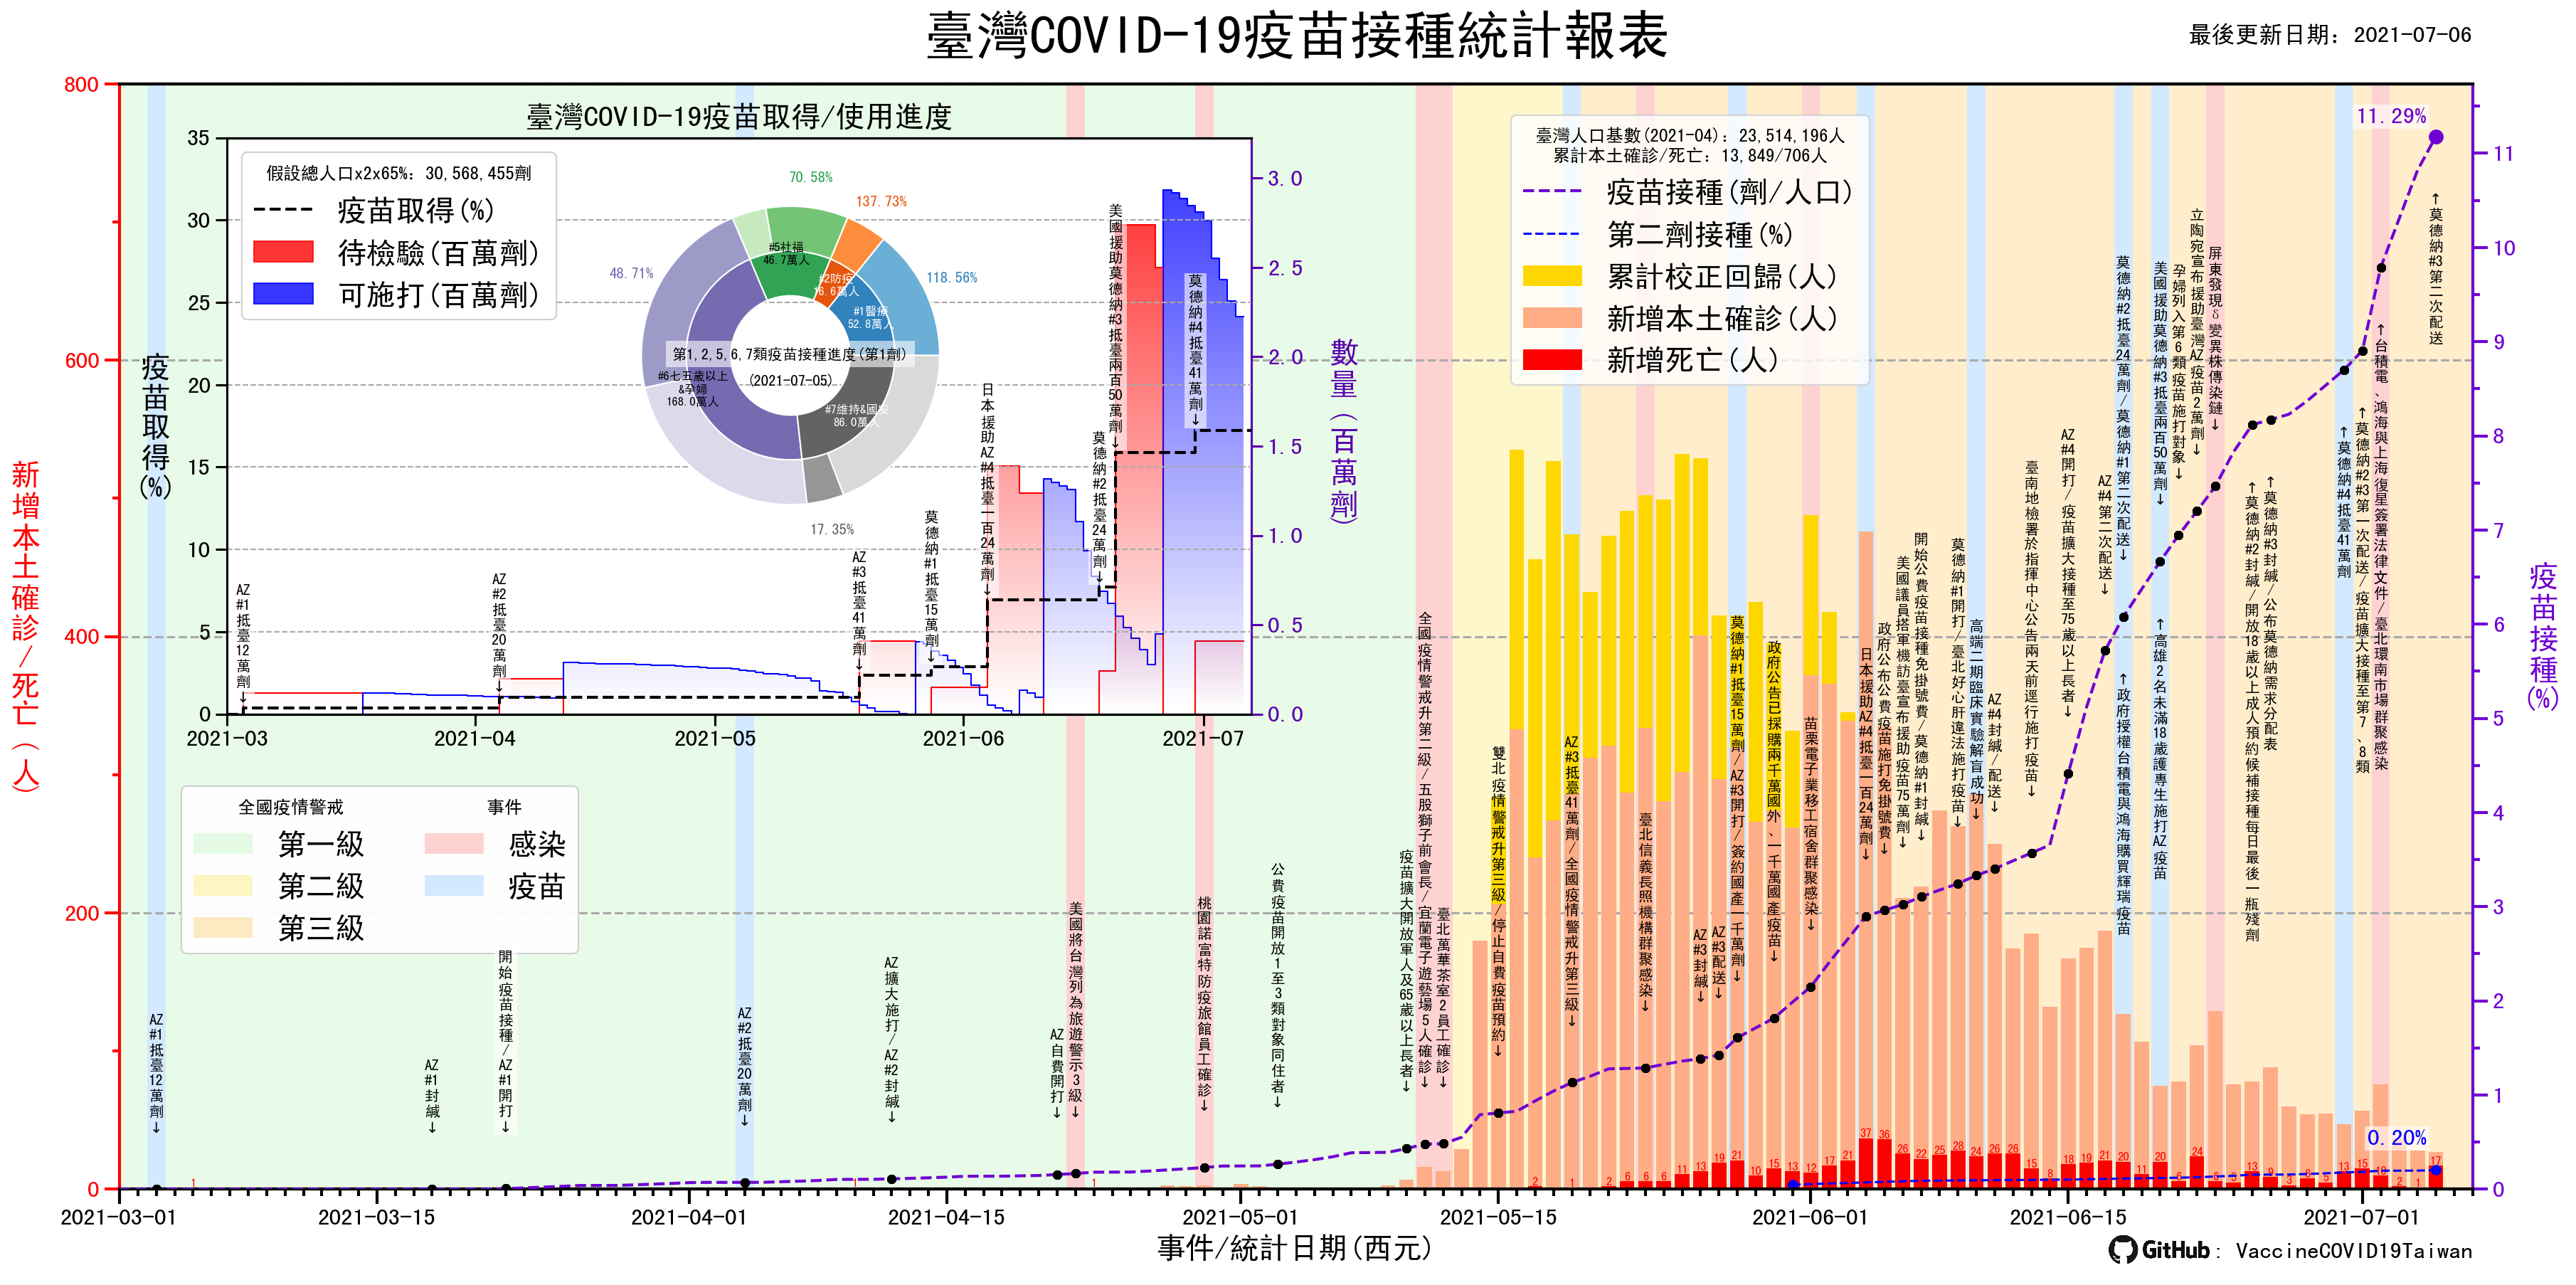

In [10]:
fig, ax_covid = plt.subplots(1,1,figsize=figsize,dpi=dpi)
plot_main(ax_covid,combo=1)

sub_size = [0.4, 0.45]
# plot vaccine progress
ax_vac_num = fig.add_axes([0.085, 0.44, sub_size[0], sub_size[1]])
plot_sub(ax_vac_num,combo=1)

# plot class
class_size = [0.24, 0.24]
ax_class = fig.add_axes([0.185, 0.6, class_size[0], class_size[1]],polar=True)
plot_class(ax_class,combo=1)

# save figure
plt.tight_layout()
plt.savefig('VaccineCOVID19Taiwan-%s.jpg'%df.index[-2].strftime('%Y-%m-%d'),dpi=dpi)
#plt.savefig('VaccineCOVID19Taiwan-%s.pdf'%df.index[-1].strftime('%Y-%m-%d'),dpi=300)

plt.show()

plt.close()

# todo: cut axis
# https://www.twblogs.net/a/5ee7eacdb4042e940f40f7c3

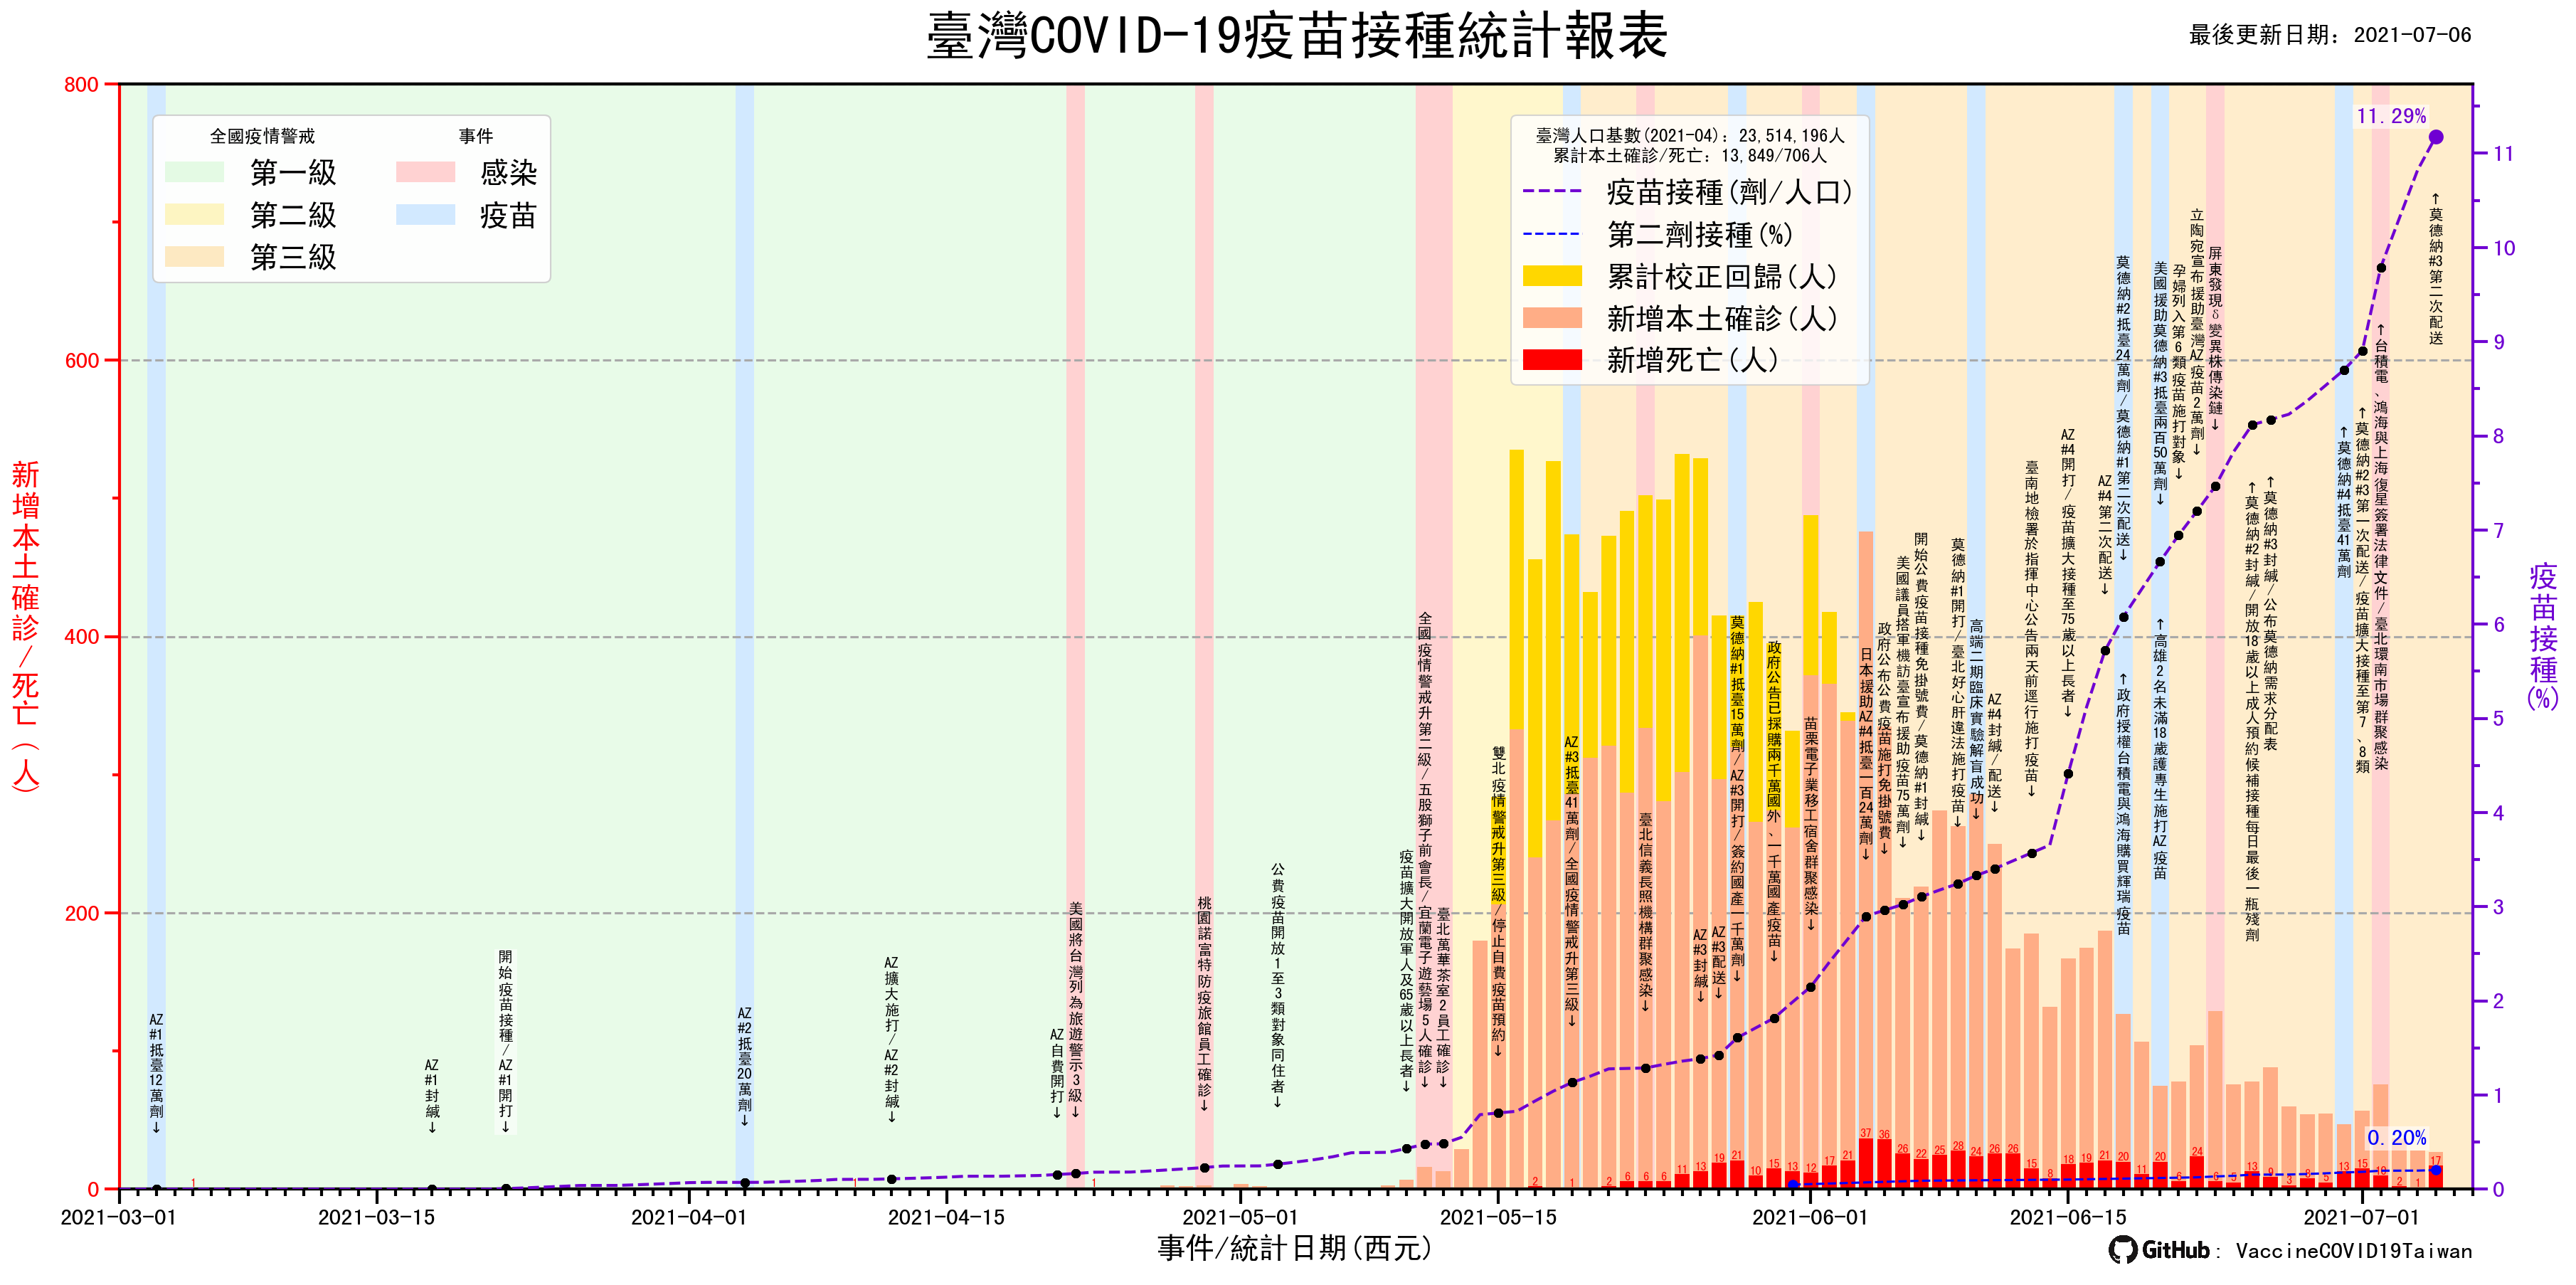

In [11]:
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

plot_main(ax)

plt.tight_layout()
plt.savefig('ax_main-%s.jpg'%df.index[-2].strftime('%Y-%m-%d'),dpi=dpi)
plt.show()
plt.close()

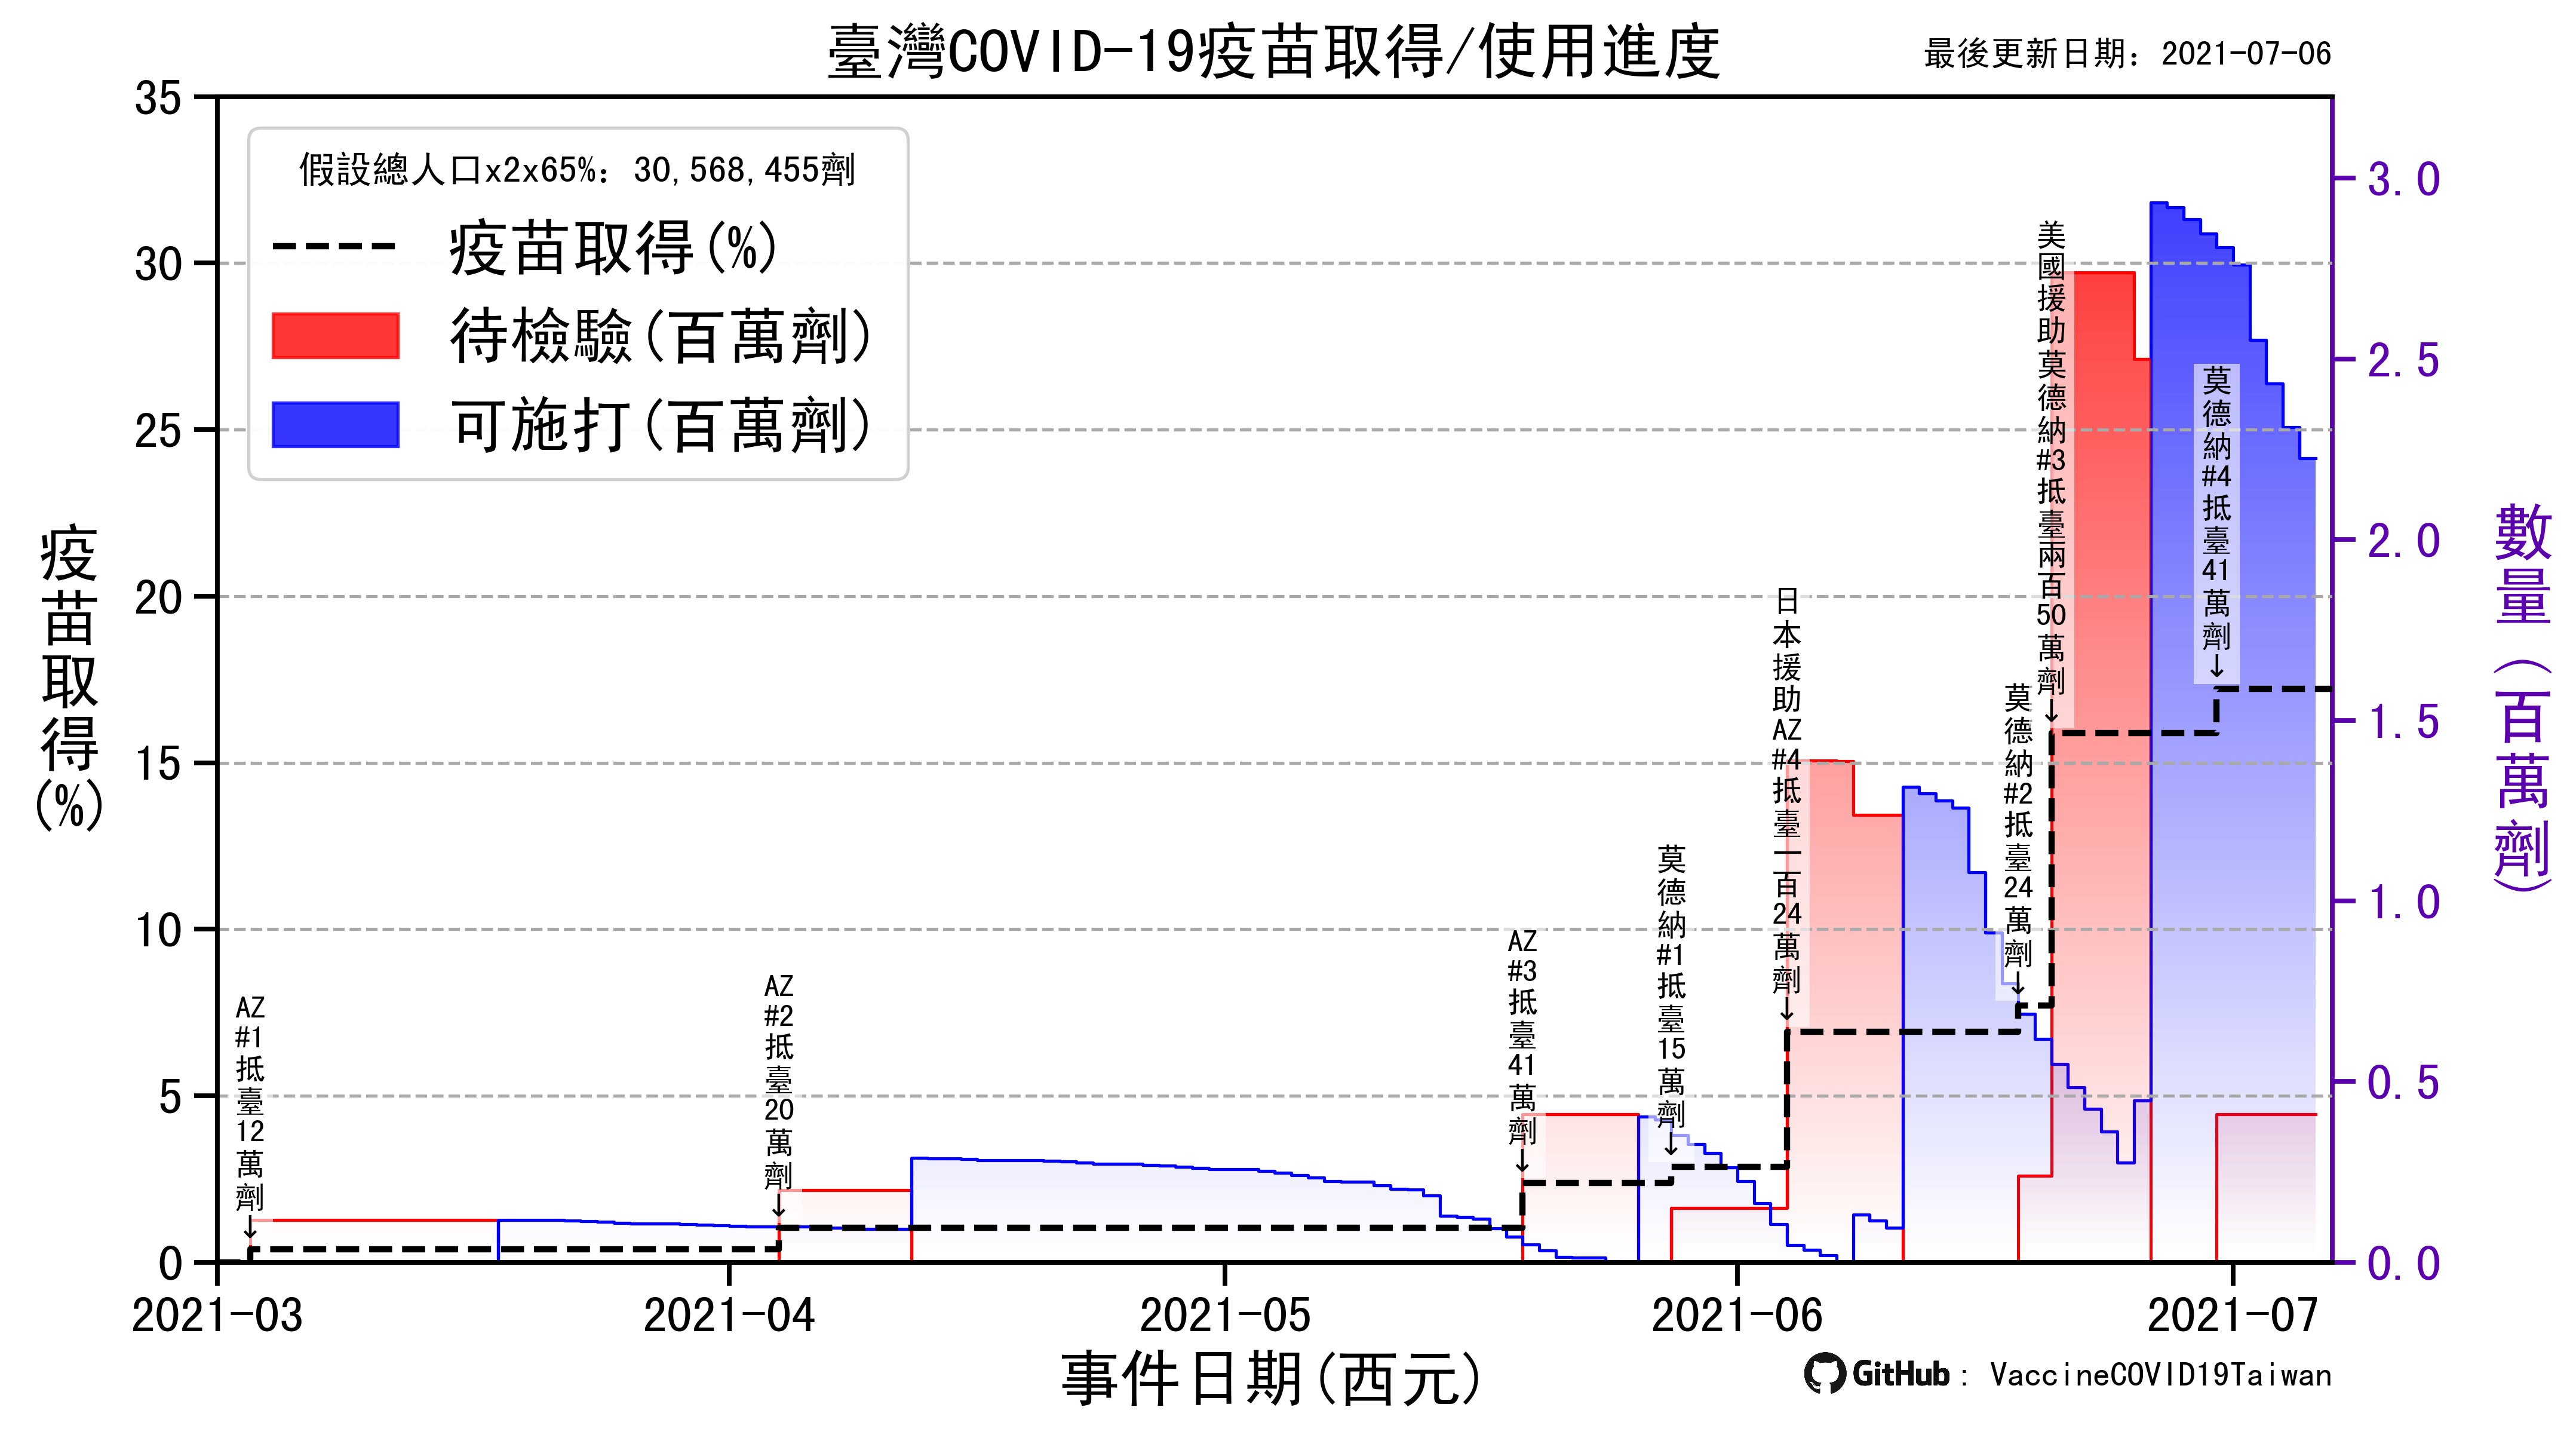

In [12]:
sub_figsize = tuple(np.array(figsize) * np.array(sub_size) * 1.2)
fig, ax = plt.subplots(1,1,figsize=sub_figsize,dpi=dpi/sub_size[0])

plot_sub(ax)
plt.tight_layout()
plt.savefig('ax_sub-%s.jpg'%df.index[-2].strftime('%Y-%m-%d'),dpi=dpi/sub_size[0])
plt.show()
plt.close()

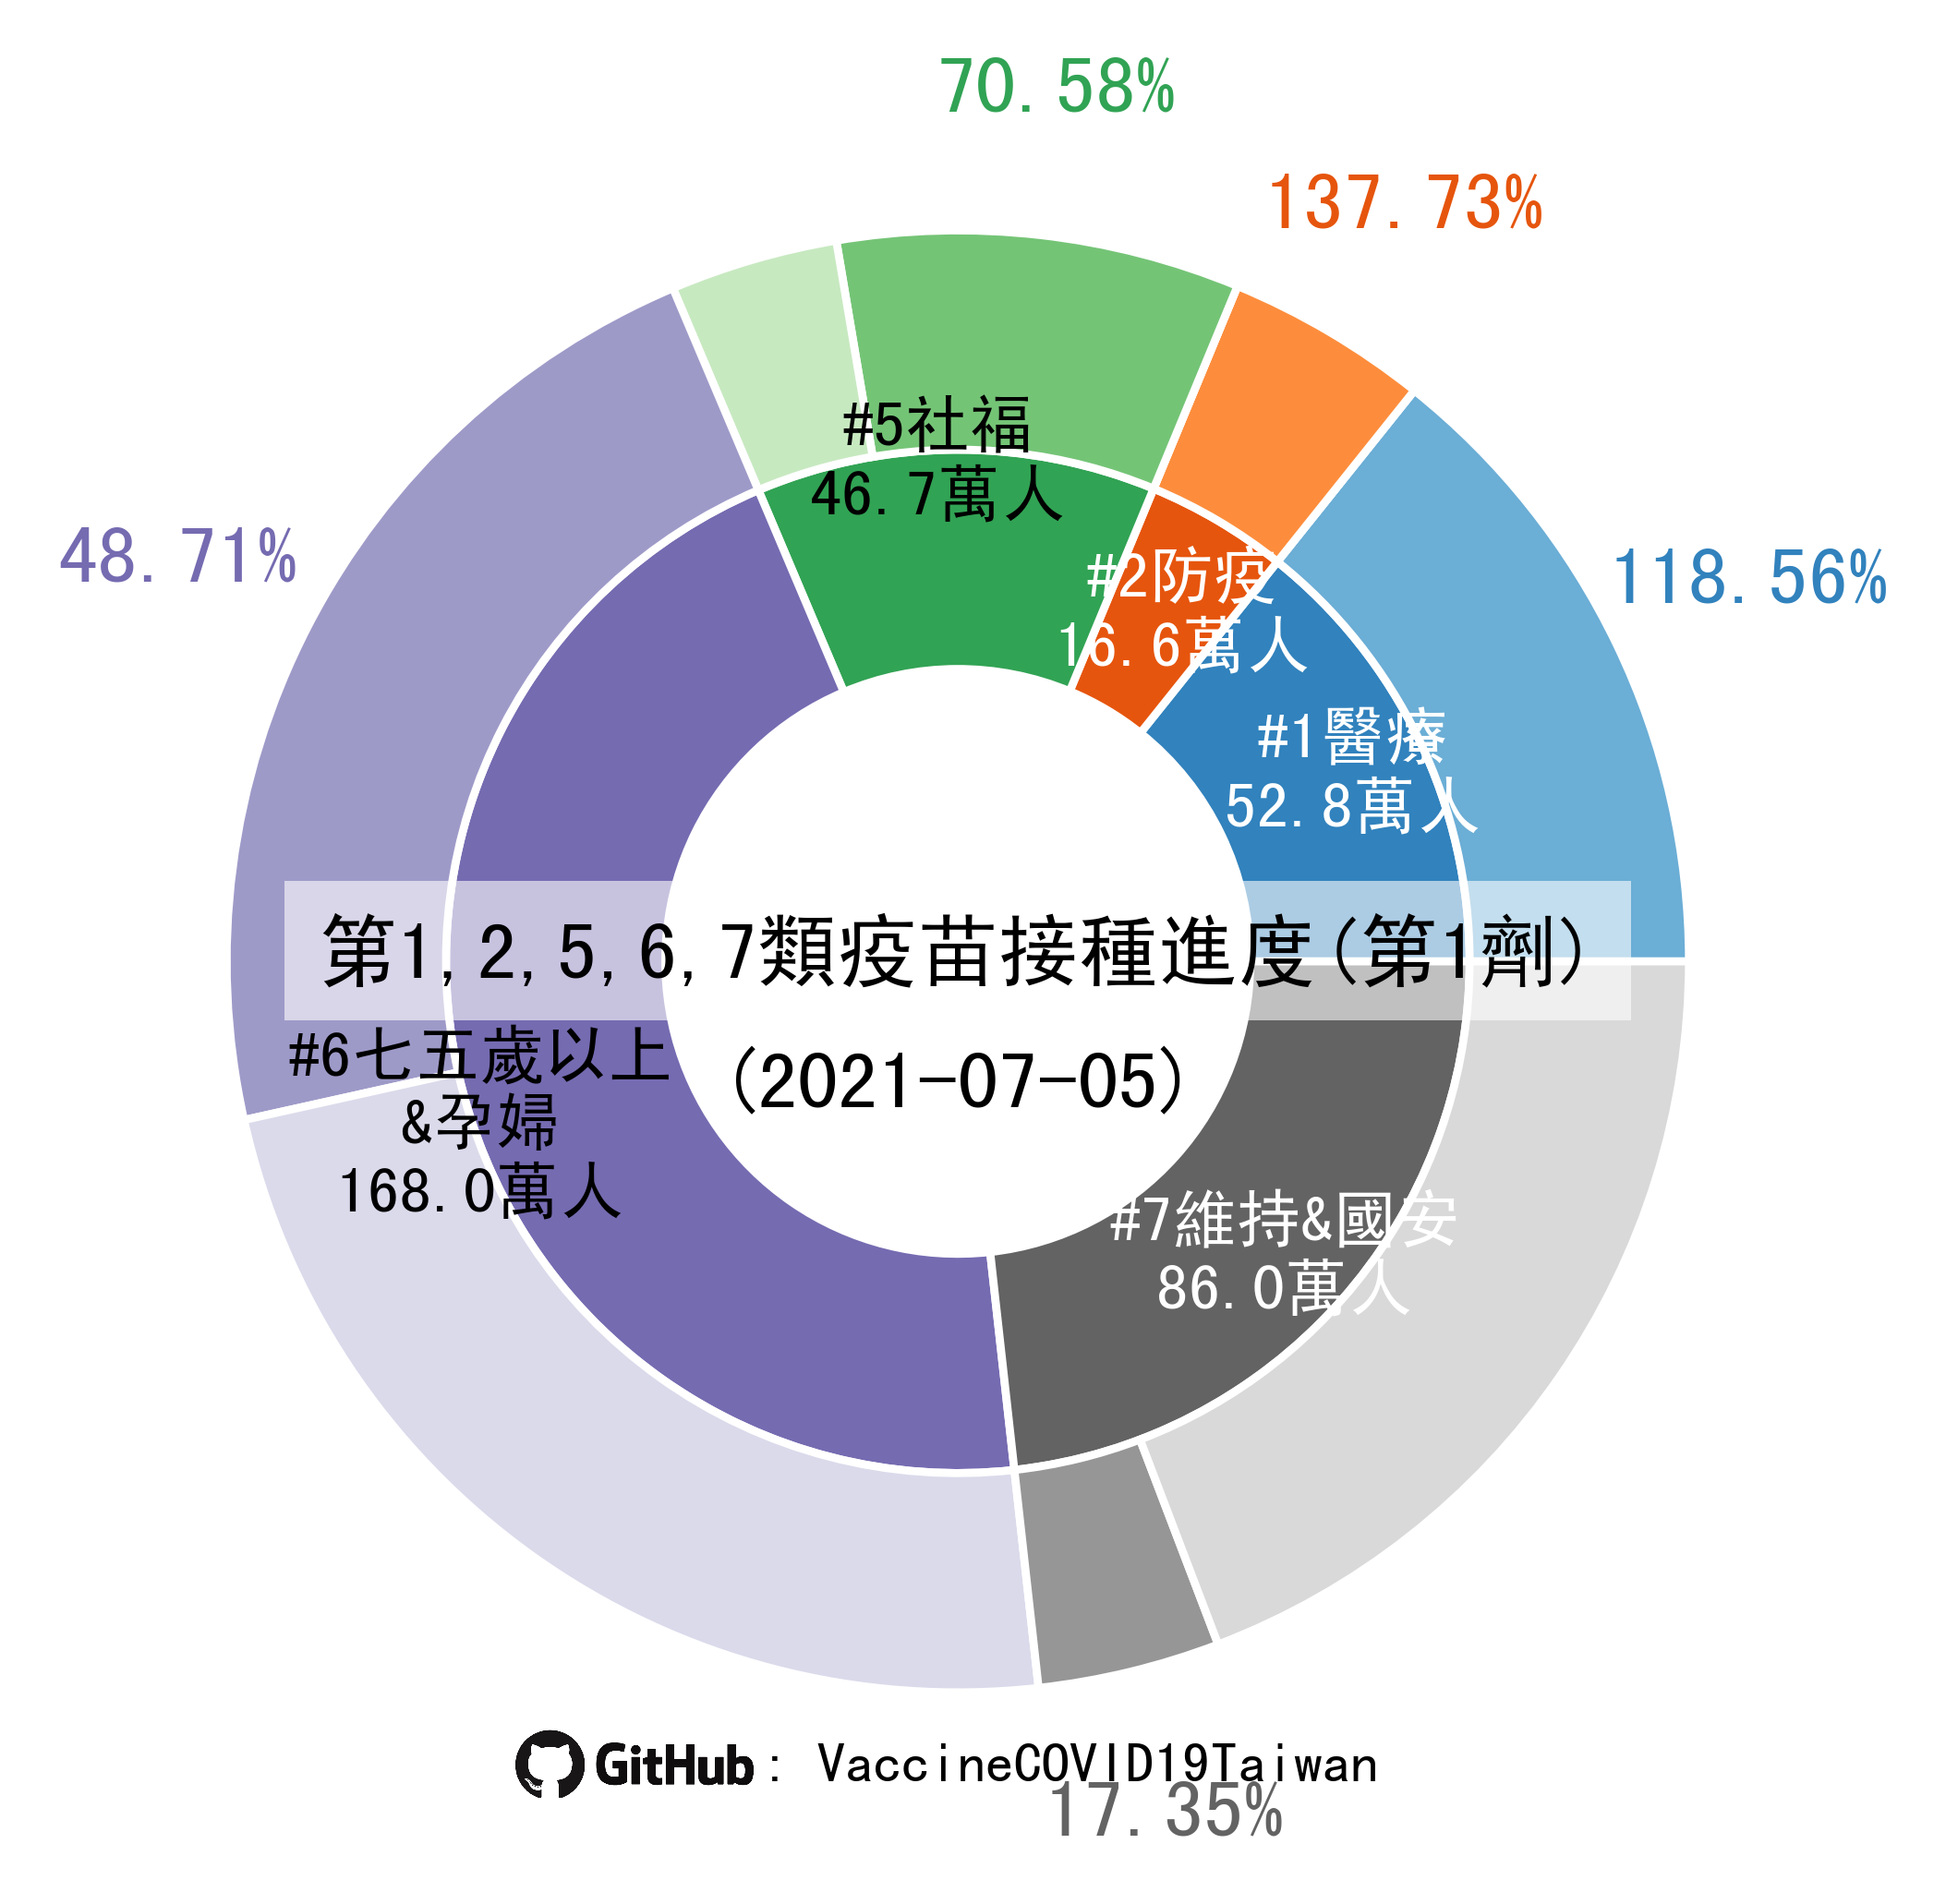

In [13]:
class_figsize = tuple(np.array(figsize) * np.array(class_size) * 1.2)
fig, ax = plt.subplots(1,1,figsize=class_figsize,dpi=dpi/class_size[0],subplot_kw=dict(polar=True))

plot_class(ax)
#plt.tight_layout()
plt.savefig('ax_class-%s.jpg'%df.index[-2].strftime('%Y-%m-%d'),dpi=dpi/class_size[0],bbox_tight=True)
plt.show()
plt.close()

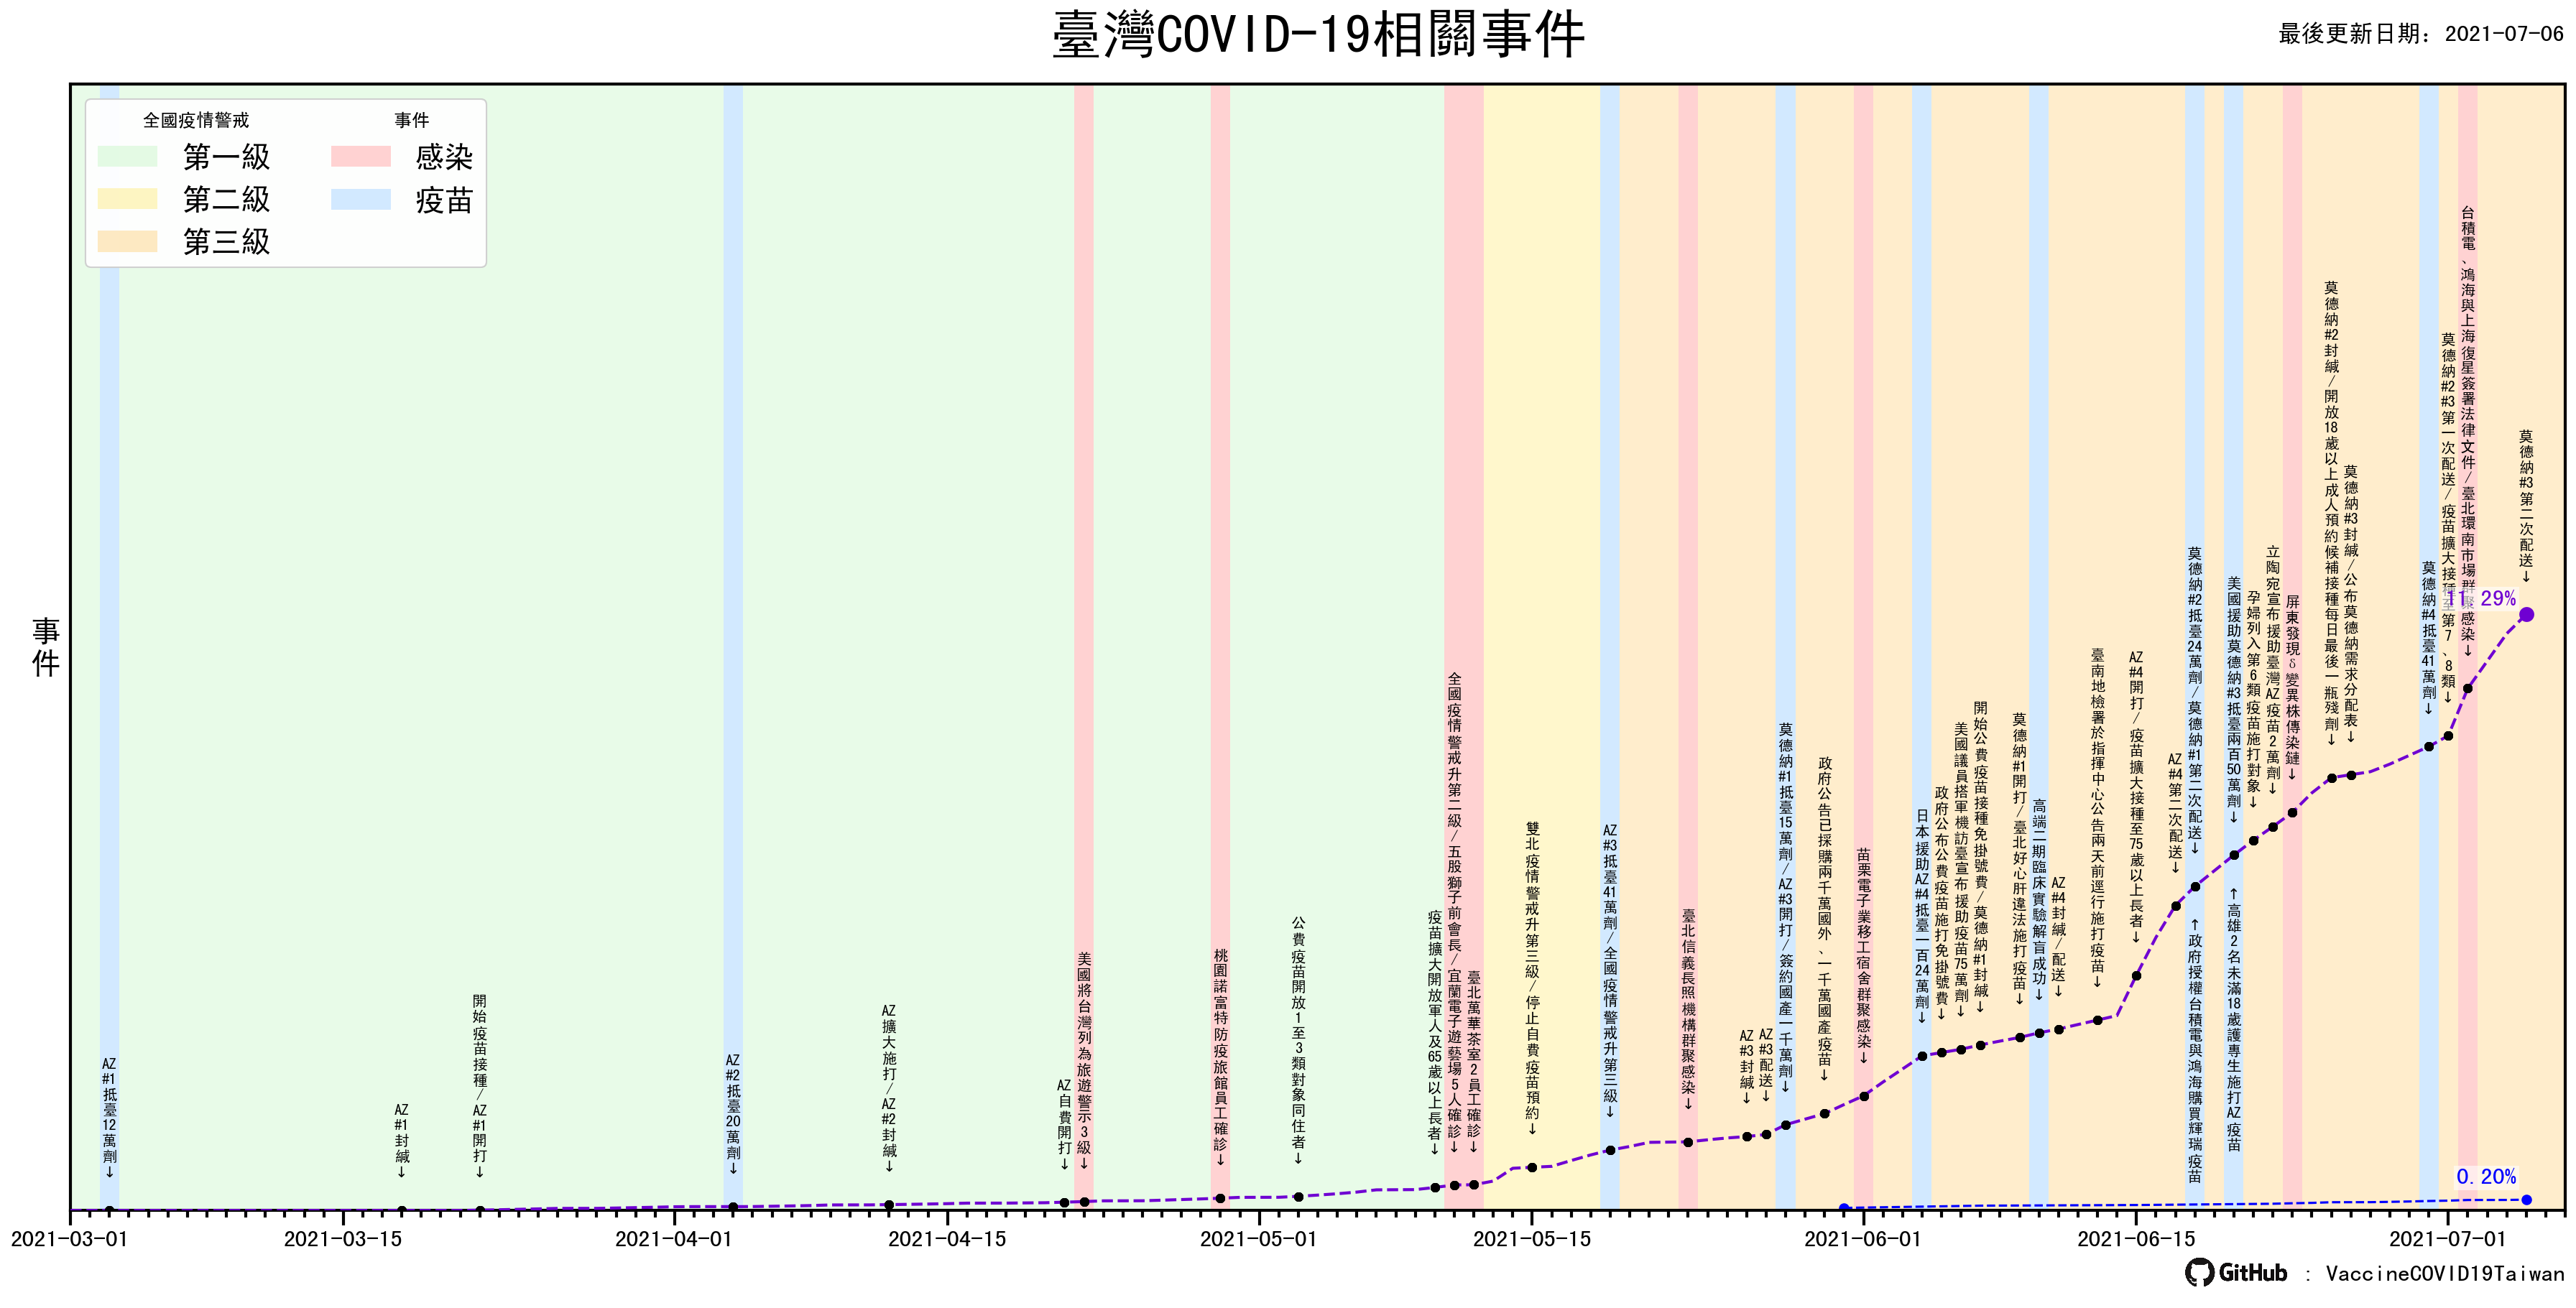

In [14]:
size_event = [1., 1.]

figsize_event = (24, 12) # 18
figsize_event = tuple( np.array(figsize_event) * np.array(size_event) )
fig, ax = plt.subplots(1,1,figsize=figsize_event,dpi=dpi/size_event[0])

plot_event(ax)

plt.tight_layout()
plt.savefig('ax_event-%s.jpg'%df.index[-2].strftime('%Y-%m-%d'),dpi=dpi/size_event[0])
plt.show()
plt.close()

In [15]:
# convert to .py
!jupyter nbconvert --to script plotVaccineCOVID19Taiwan.ipynb

[NbConvertApp] Converting notebook plotVaccineCOVID19Taiwan.ipynb to script
[NbConvertApp] Writing 33531 bytes to plotVaccineCOVID19Taiwan.py
